# Data Cleansing and Preparation:
## The following data cleansing and preparation steps were followed by the work in the source below:
### https://www.kaggle.com/code/ahmedislam0/phishing-url-detection-96-accuracy
## The Random Forest Decision Tree model implementation, analysis, and evaluation are unique to this notebook.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pickle
pd.set_option('display.max_columns', None)

In [6]:
# Import Dataset
df = pd.read_csv('../../../data/dataset_phishing.csv')
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,3,0,0,0,0,0,0,4,4,3,3,3,11,11,6,5.750000,7.0,4.500000,0,0,0,0,0,0,17,0.529412,0.470588,0,0,0,0.875000,0,0.500000,0,0,80.000000,0,100.000000,0.000000,0,0,0,0.0,0,0,0,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,0,0,0,0,1,0.220779,0.0,0,0,0,0,0,1,0,0,0,0,1,0,4,4,2,19,2,32,19,32,15.750000,19.0,14.666667,0,0,0,0,0,0,30,0.966667,0.033333,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,80.000000,20.000000,0,0,0,100.0,0,0,0,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,3,2,0,0,5,0,1,0,0,0,0,0,1,0,0,0,0.150794,0.0,0,0,0,1,0,3,1,0,0,0,1,0,12,2,2,3,2,17,13,17,8.250000,8.4,8.142857,0,0,0,0,0,0,4,1.000000,0.000000,0,0,0,0.000000,0,0.000000,0,0,100.000000,0,0.000000,0.000000,0,0,0,100.0,0,0,0,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,1,0,5,5,0,5,5,0,5.000000,5.0,0.000000,0,0,0,0,0,0,149,0.973154,0.026846,0,0,0,0.250000,0,0.250000,0,0,100.000000,0,96.428571,3.571429,0,0,0,62.5,0,0,0,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,0,1,0.000000,0.0,0,0,0,0,0,2,0,0,0,0,1,0,6,3,3,3,4,11,7,11,6.333333,5.0,7.000000,0,0,0,0,0,0,102,0.470588,0.529412,0,0,0,0.537037,0,0.018519,1,0,76.470588,0,0.000000,100.000000,0,0,0,0.0,0,0,0,0,1,0,224,8175,8725,0,0,6,legitimate


### How many of these columns have null columns? If null we need to remove them.

In [9]:
df.isna().sum()

url                0
length_url         0
length_hostname    0
ip                 0
nb_dots            0
                  ..
web_traffic        0
dns_record         0
google_index       0
page_rank          0
status             0
Length: 89, dtype: int64

In [11]:
# removing missing values

df.dropna(inplace=True)

### Set up an array of the features "the columns" we want to include in our study.

In [14]:
features = [
    'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq',
    'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn',
    'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url',
    'ratio_digits_host', 'punycode', 'shortening_service', 'path_extension', 'phish_hints', 'domain_in_brand',
    'brand_in_subdomain', 'brand_in_path', 'suspecious_tld'
]

In [16]:
# Target feature mapping, meaning mapping our known answers to a numeric value.

df['status'] = df['status'].map({'phishing': 1, 'legitimate': 0})

# Verifying that we have a perfectly balanced data set for training, 5715 phishing and legitimate entries. 

In [19]:
df['status'].value_counts()

status
0    5715
1    5715
Name: count, dtype: int64

### Gives general information about the dataset

In [22]:
df.describe()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_star,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,nb_dslash,http_in_path,https_token,ratio_digits_url,ratio_digits_host,punycode,port,tld_in_path,tld_in_subdomain,abnormal_subdomain,nb_subdomains,prefix_suffix,random_domain,shortening_service,path_extension,nb_redirection,nb_external_redirection,length_words_raw,char_repeat,shortest_words_raw,shortest_word_host,shortest_word_path,longest_words_raw,longest_word_host,longest_word_path,avg_words_raw,avg_word_host,avg_word_path,phish_hints,domain_in_brand,brand_in_subdomain,brand_in_path,suspecious_tld,statistical_report,nb_hyperlinks,ratio_intHyperlinks,ratio_extHyperlinks,ratio_nullHyperlinks,nb_extCSS,ratio_intRedirection,ratio_extRedirection,ratio_intErrors,ratio_extErrors,login_form,external_favicon,links_in_tags,submit_email,ratio_intMedia,ratio_extMedia,sfh,iframe,popup_window,safe_anchor,onmouseover,right_clic,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
count,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.0,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.0,11430.000000,11430.0,11430.000000,11430.0,11430.000000,11430.000000,11430.000000,11430.000000,11430.0,11430.000000,11430.000000,11430.0,11430.000000,11430.000000,11430.000000,11430.000000,11430.00000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,1.143000e+04,11430.000000,11430.000000,11430.000000,11430.000000
mean,61.126684,21.090289,0.150569,2.480752,0.997550,0.022222,0.141207,0.162292,0.0,0.293176,0.322660,0.006649,0.123097,4.289589,0.000700,1.027909,0.004024,0.062292,0.001925,0.034821,0.448469,0.127997,0.006562,0.016710,0.610936,0.053137,0.025024,0.000350,0.002362,0.065617,0.050131,0.021610,2.231671,0.202450,0.083290,0.123447,0.000175,0.498250,0.003150,6.232808,2.927472,3.127297,5.019773,2.398950,15.393876,10.467979,10.561505,7.258882,7.678075,5.092425,0.327734,0.104199,0.004112,0.004899,0.017935,0.059755,87.189764,0.602457,0.276720,0.0,0.784864,0.0,0.158926,0.0,0.062469,0.063605,0.442170,51.978211,0.0,42.870444,23.236293,0.0,0.001312,0.006037,37.063922,0.001137,0.00140,0.124759,0.775853,0.439545,0.072878,492.532196,4062.543745,8.567566e+05,0.020122,0.533946,3.185739,0.500000
std,55.297318,10.777171,0.357644,1.369686,2.087087,0.155500,0.364456,0.821337,0.0,0.998317,1.093336,0.081274,1.466450,1.882251,0.026448,0.240325,0.103240,0.598190,0.077111,0.375576,0.501912,0.379008,0.080742,0.169358,0.487559,0.089363,0.093422,0.018705,0.048547,0.247622,0.218225,0.145412,0.637069,0.401843,0.276332,0.328964,0.013227,0.691907,0.056035,5.572355,4.768936,2.211571,3.941580,2.997809,22.083644,4.932015,23.077883,4.145827,3.578435,7.147050,0.842600,0.305533,0.063996,0.069827,0.132722,0.331266,166.758254,0.376474,0.319958,0.0,2.758802,0.0,0.266437,0.0,0.156209,0.244058,0.496666,41.523144,0.0,46.249897,38.386577,0.0,0.036204,0.077465,39.073385,0.033707,0.03739,0.330460,0.417038,0.496353,0.259948,814.769415,3107.784600,1.995606e+06,0.140425,0.498868,2.536955,0.500022
min,12.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.0000

### Gives number of rows, number of columns

In [25]:
df.shape

(11430, 89)

### Gives information about the datatypes for the features, non-null values

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

In [30]:
# Select only the numerical columns from the dataframe that are float64 or int64 to rull out objects.
numerical_df = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix on the numerical columns.
corr_matrix = numerical_df.corr()

In [32]:
status_corr = corr_matrix['status']
status_corr.shape

(88,)

In [34]:
# Function for selecting features that are above than threshold value

def feature_selector_correlation(cmatrix, threshold):

    selected_features = []
    feature_score = []
    i=0
    for score in cmatrix:
        if abs(score)>threshold:
            selected_features.append(cmatrix.index[i])
            feature_score.append( ['{:3f}'.format(score)])
        i+=1
    result = list(zip(selected_features,feature_score))
    return result

In [36]:
features_selected = feature_selector_correlation(status_corr, 0.2)
features_selected

[('length_url', ['0.248580']),
 ('length_hostname', ['0.238322']),
 ('ip', ['0.321698']),
 ('nb_dots', ['0.207029']),
 ('nb_qm', ['0.294319']),
 ('nb_eq', ['0.233386']),
 ('nb_slash', ['0.242270']),
 ('nb_www', ['-0.443468']),
 ('ratio_digits_url', ['0.356395']),
 ('ratio_digits_host', ['0.224335']),
 ('tld_in_subdomain', ['0.208884']),
 ('prefix_suffix', ['0.214681']),
 ('shortest_word_host', ['0.223084']),
 ('longest_words_raw', ['0.200147']),
 ('longest_word_path', ['0.212709']),
 ('phish_hints', ['0.335393']),
 ('nb_hyperlinks', ['-0.342628']),
 ('ratio_intHyperlinks', ['-0.243982']),
 ('empty_title', ['0.207043']),
 ('domain_in_title', ['0.342807']),
 ('domain_age', ['-0.331889']),
 ('google_index', ['0.731171']),
 ('page_rank', ['-0.511137']),
 ('status', ['1.000000'])]

In [38]:
selected_features = []
for feature, score in features_selected:
    if feature != 'status':
        selected_features.append(feature)

In [40]:
selected_features

['length_url',
 'length_hostname',
 'ip',
 'nb_dots',
 'nb_qm',
 'nb_eq',
 'nb_slash',
 'nb_www',
 'ratio_digits_url',
 'ratio_digits_host',
 'tld_in_subdomain',
 'prefix_suffix',
 'shortest_word_host',
 'longest_words_raw',
 'longest_word_path',
 'phish_hints',
 'nb_hyperlinks',
 'ratio_intHyperlinks',
 'empty_title',
 'domain_in_title',
 'domain_age',
 'google_index',
 'page_rank']

In [42]:
X = df[selected_features]
y = df['status']

# This next code block performs 10-fold cross-validation on the dataset using various configurations of 
the Random Forest Classifier, with standardized input features. 

1. **Standard Scaling**: The feature matrix `X` is scaled using `StandardScaler`, which standardizes the data by 
   removing the mean and scaling it to unit variance. This ensures that features with different scales don't negatively 
   affect model performance.

2. **Random Forest Configurations**: Six different Random Forest models are tested, varying in parameters such as 
   the number of trees (`n_estimators`), maximum tree depth (`max_depth`), and class weight balancing to handle 
   potential class imbalances.

3. **10-fold Cross-Validation**: The `cross_val_score` function performs 10-fold cross-validation, where the dataset 
   is split into 10 subsets. The model is trained on 9 subsets and evaluated on the remaining subset, repeating this 
   process across all 10 folds. This provides a robust evaluation of model performance by mitigating the risk of 
   overfitting and ensuring that the model generalizes well to unseen data.

4. **Evaluation Metrics**: For each model, the accuracy for each fold and the average accuracy across all folds is 
   calculated and displayed. This allows the user to compare the performance of various model configurations 
   and choose the best one based on cross-validation results.

By scaling the data and using cross-validation, this approach provides a comprehensive evaluation of the 
Random Forest models, ensuring they are robust and generalizable for new data.

# Analysis and Results
Performing 10-fold cross-validation and computing the confusion matrix gives a detailed breakdown of how well the model predicted each class in comparison to the actual classes across all 10 folds.

- True Negatives (TN): The number of negative examples (class 0) correctly predicted as negative.
- False Positives (FP): The number of negative examples (class 0) incorrectly predicted as positive (class 1).
- False Negatives (FN): The number of positive examples (class 1) incorrectly predicted as negative (class 0).
- True Positives (TP): The number of positive examples (class 1) correctly predicted as positive.

```
                Predicted Class
               |   0   |   1   |
    True Class |-------|-------|
        0      |  TN   |  FP   |
        1      |  FN   |  TP   |


```
1. **Precision:**
- Definition: Precision is the ratio of correctly predicted positive observations to the total predicted positives.
- Formula: Precision = TP / (TP + FP)
- Interpretation: Precision tells you how accurate your positive predictions were. If the model predicted 100 instances as True, precision measures how   many of those predictions were actually True.
2. **Recall:**
- Definition: Recall (also called Sensitivity or True Positive Rate) is the ratio of correctly predicted positive observations to all observations in     the actual positive class.
- Formula: Recall = TP / (TP + FN)
- Interpretation: Recall tells you how well the model identifies actual positive cases. If 100 instances were truly True, recall measures how many of     those were correctly predicted by the model.
3. **F1-Score:**
- Definition: The F1-score is the harmonic mean of precision and recall, balancing the two. It is a better measure than accuracy when dealing with        imbalanced classes, as it considers both false positives and false negatives.
- Formula: F1-Score = 2 * (Precision * Recall) / (Precision + Recall)
- Interpretation: F1-score combines precision and recall into a single metric. It provides a balanced measure when the class distribution is imbalanced.
4. **Support:**
- Definition: Support is simply the number of actual occurrences of each class in the dataset.
- Interpretation: It tells you how many instances of each class were present in the dataset, and it helps contextualize the metrics. A class with low     support may have less reliable metrics because there were fewer examples to learn from.

============================== Random Forest Classifier 100 trees Cross-Validation Evaluation ==============================
Accuracy for each fold: [0.96587927 0.96675416 0.96675416 0.96500437 0.9623797  0.96762905
 0.95625547 0.95450569 0.96937883 0.96675416]
Mean Accuracy across folds: 0.9641
Model Accuracy (combined prediction): 96.41%
Confusion Matrix:
 [[5509  206]
 [ 204 5511]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      5715
           1       0.96      0.96      0.96      5715

    accuracy                           0.96     11430
   macro avg       0.96      0.96      0.96     11430
weighted avg       0.96      0.96      0.96     11430




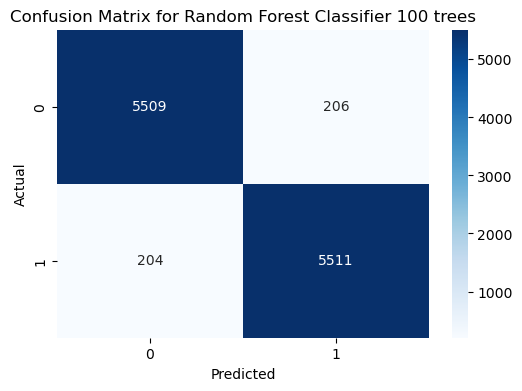

============================== Random Forest Classifier 200 trees Cross-Validation Evaluation ==============================
Accuracy for each fold: [0.96850394 0.96587927 0.96412948 0.96587927 0.9623797  0.96850394
 0.9536308  0.95538058 0.97112861 0.96412948]
Mean Accuracy across folds: 0.9640
Model Accuracy (combined prediction): 96.40%
Confusion Matrix:
 [[5502  213]
 [ 199 5516]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96      5715
           1       0.96      0.97      0.96      5715

    accuracy                           0.96     11430
   macro avg       0.96      0.96      0.96     11430
weighted avg       0.96      0.96      0.96     11430




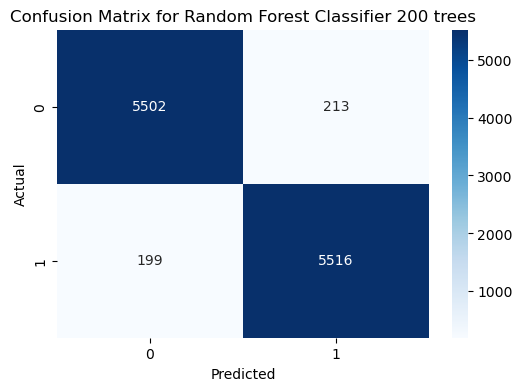

============================== Random Forest Classifier 300 trees Cross-Validation Evaluation ==============================
Accuracy for each fold: [0.96500437 0.96500437 0.96500437 0.96675416 0.95975503 0.96850394
 0.95713036 0.95713036 0.97025372 0.96412948]
Mean Accuracy across folds: 0.9639
Model Accuracy (combined prediction): 96.39%
Confusion Matrix:
 [[5504  211]
 [ 202 5513]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      5715
           1       0.96      0.96      0.96      5715

    accuracy                           0.96     11430
   macro avg       0.96      0.96      0.96     11430
weighted avg       0.96      0.96      0.96     11430




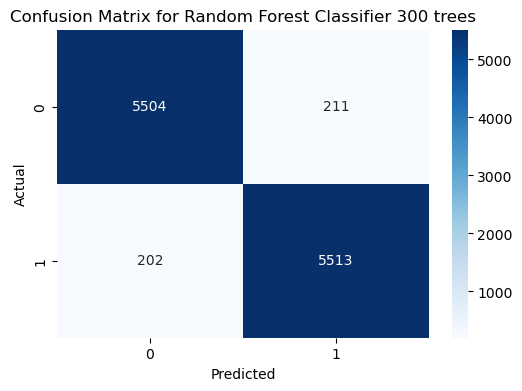

============================== Random Forest Classifier with max depth 10 Cross-Validation Evaluation ==============================
Accuracy for each fold: [0.95975503 0.95888014 0.96412948 0.95713036 0.95713036 0.95800525
 0.9536308  0.94925634 0.96325459 0.95888014]
Mean Accuracy across folds: 0.9580
Model Accuracy (combined prediction): 95.80%
Confusion Matrix:
 [[5485  230]
 [ 250 5465]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      5715
           1       0.96      0.96      0.96      5715

    accuracy                           0.96     11430
   macro avg       0.96      0.96      0.96     11430
weighted avg       0.96      0.96      0.96     11430




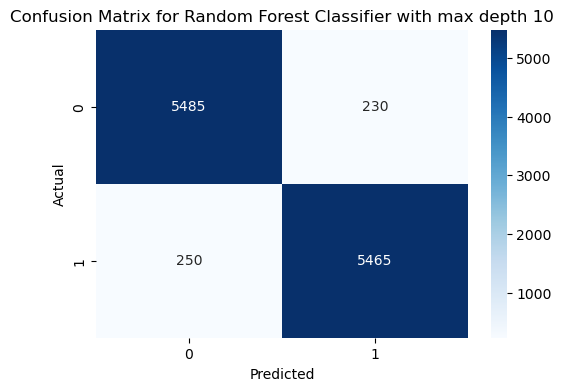

============================== Random Forest Classifier with max depth 20 Cross-Validation Evaluation ==============================
Accuracy for each fold: [0.96325459 0.96675416 0.96675416 0.9623797  0.96062992 0.96675416
 0.95888014 0.95713036 0.97112861 0.9623797 ]
Mean Accuracy across folds: 0.9636
Model Accuracy (combined prediction): 96.36%
Confusion Matrix:
 [[5501  214]
 [ 202 5513]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      5715
           1       0.96      0.96      0.96      5715

    accuracy                           0.96     11430
   macro avg       0.96      0.96      0.96     11430
weighted avg       0.96      0.96      0.96     11430




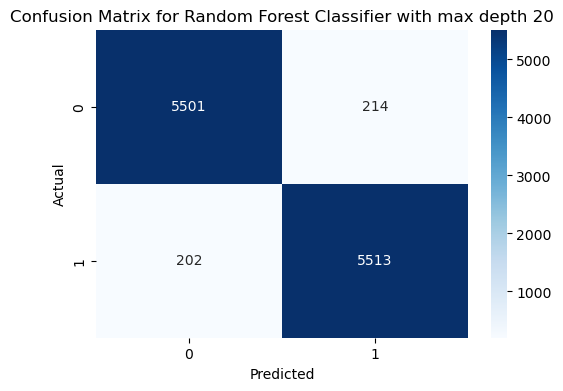

============================== Random Forest Classifier with balanced class weight Cross-Validation Evaluation ==============================
Accuracy for each fold: [0.96412948 0.96412948 0.96675416 0.95888014 0.95800525 0.96762905
 0.95888014 0.95625547 0.97287839 0.96325459]
Mean Accuracy across folds: 0.9631
Model Accuracy (combined prediction): 96.31%
Confusion Matrix:
 [[5498  217]
 [ 205 5510]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      5715
           1       0.96      0.96      0.96      5715

    accuracy                           0.96     11430
   macro avg       0.96      0.96      0.96     11430
weighted avg       0.96      0.96      0.96     11430




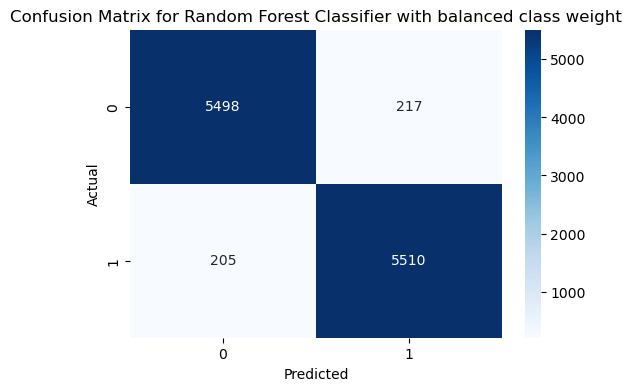

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X is your feature matrix and y is your target variable (classification labels)
# X = df[selected_features]
# y = df['status']

# Initialize the StandardScaler and scale the entire feature matrix X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define different variations of the Random Forest Classifier
models = [
    ('Random Forest Classifier 100 trees', RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)),
    ('Random Forest Classifier 200 trees', RandomForestClassifier(n_estimators=200, random_state=0, n_jobs=-1)),
    ('Random Forest Classifier 300 trees', RandomForestClassifier(n_estimators=300, random_state=0, n_jobs=-1)),
    ('Random Forest Classifier with max depth 10', RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, n_jobs=-1)),
    ('Random Forest Classifier with max depth 20', RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0, n_jobs=-1)),
    ('Random Forest Classifier with balanced class weight', RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=0, n_jobs=-1))
]

# Function to evaluate the Random Forest models using cross-validation
def evaluate_model_cv(model, X, y, model_name):
    print(f'============================== {model_name} Cross-Validation Evaluation ==============================')
    
    # Perform 10-fold cross-validation and predict using cross_val_predict
    y_pred = cross_val_predict(model, X, y, cv=10, n_jobs=-1)
    
    # Calculate Accuracy, Confusion Matrix, and Classification Report
    accuracy = accuracy_score(y, y_pred)
    confusion_matrix_result = confusion_matrix(y, y_pred)
    classification = classification_report(y, y_pred)
    
    # Perform 10-fold cross-validation to get accuracy for each fold
    scores = cross_val_score(model, X, y, cv=10, scoring='accuracy', n_jobs=-1)
    
    # Print evaluation results
    print(f"Accuracy for each fold: {scores}")
    print(f"Mean Accuracy across folds: {np.mean(scores):.4f}")
    print(f"Model Accuracy (combined prediction): {accuracy * 100:.2f}%")
    print('Confusion Matrix:\n', confusion_matrix_result)
    print('Classification Report:\n', classification)
    print()

    # Plot confusion matrix using seaborn
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Iterate through each Random Forest model and evaluate using cross-validation
for model_name, model in models:
    evaluate_model_cv(model, X_scaled, y, model_name)